## Advanced Lanes Finding
 The goals of project are:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

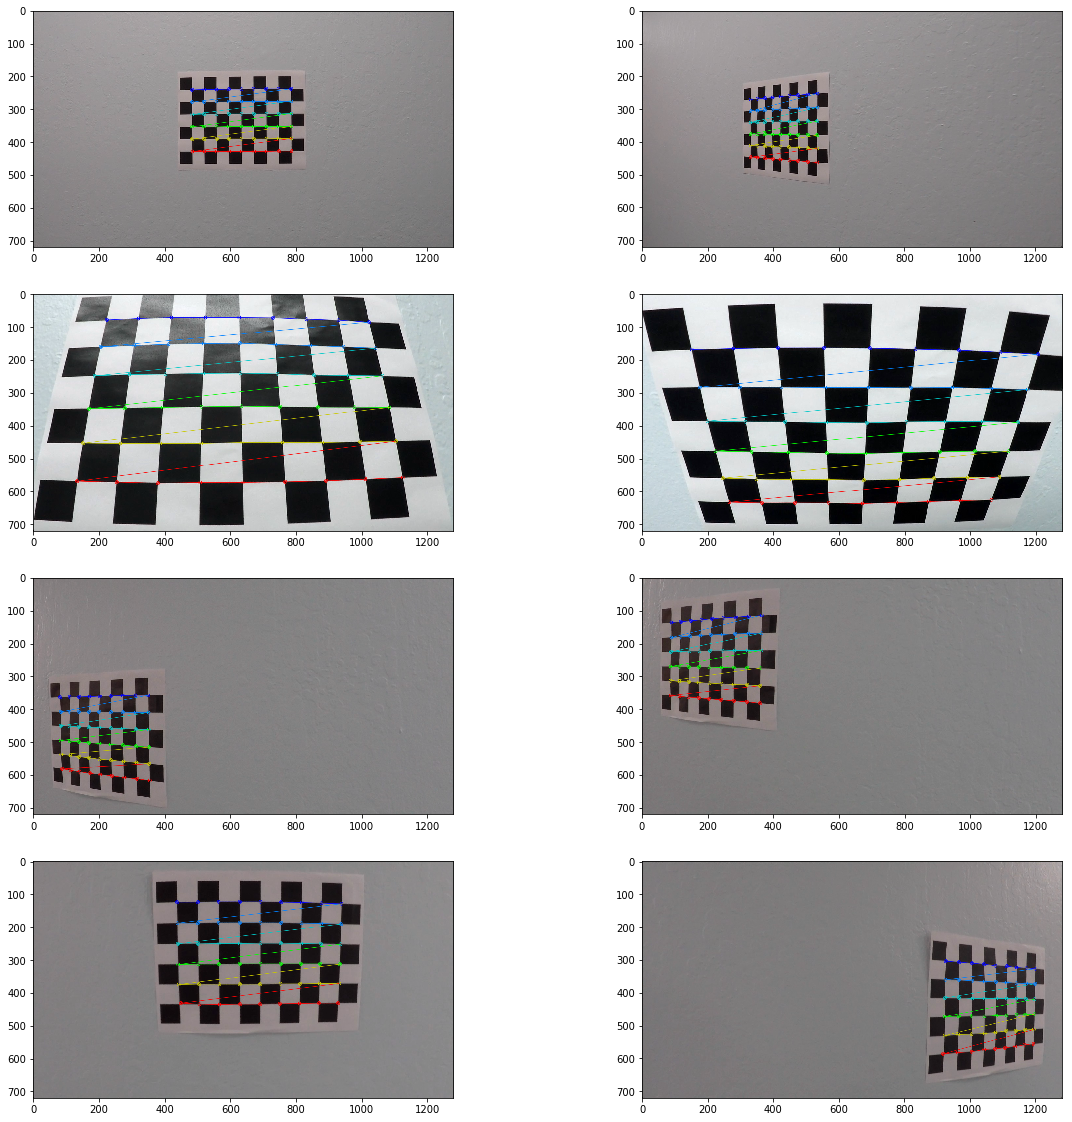

In [1]:
# Detect chessboard corners
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
img_size = None

fig, axes = plt.subplots(4,2, figsize=(20, 20))

# Step through the list and search for chessboard corners
n_count = 0
for fname in images:
    img = cv2.imread(fname)
    img_size = img.shape
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if n_count < 8:
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            axes[n_count//2, n_count%2].imshow(img)
            n_count += 1

In [2]:
# Compute Camera Calibration Matrix and Distortion Coefficients
ret, mtx, dist, revecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_size[1], img_size[0]), None, None)

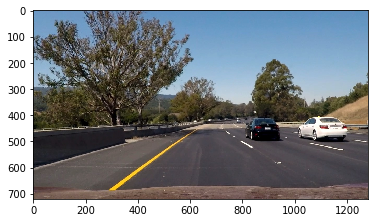

In [3]:
# Read sample image
import os
images = glob.glob('./test_images/*.jpg')

img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

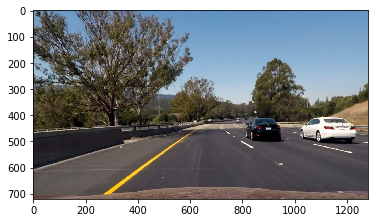

In [4]:
# Undistortion
dst = cv2.undistort(img, mtx, dist)
dst_ = copy.deepcopy(dst)
plt.imshow(dst_)

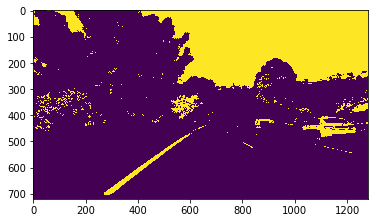

In [5]:
# Thresholding with color
hls_thresh_img = hls_select(dst, thresh2=(40, 255), thresh3=(90, 255))
mask_color_img = np.ones_like(dst) * 255
plt.imshow(hls_thresh_img)

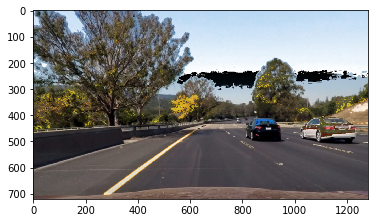

In [6]:
# Color (S,L) enhancement
dst = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
dst[(hls_thresh_img == 1), 1:3] += 70
dst = cv2.cvtColor(dst, cv2.COLOR_HLS2RGB)
dst = cv2.GaussianBlur(dst, (3, 3), 0)
plt.imshow(dst)

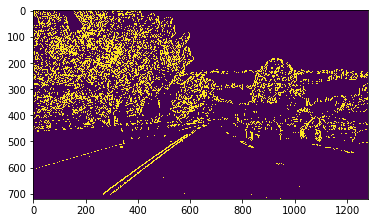

In [7]:
# Thresholding image with gradients
img_sobelx = abs_sobel_thresh(dst, 'x', 20, 255)
plt.imshow(img_sobelx)

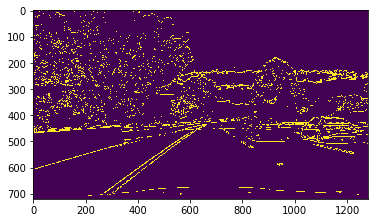

In [8]:
img_sobely = abs_sobel_thresh(dst, 'y', 40, 255)
plt.imshow(img_sobely)

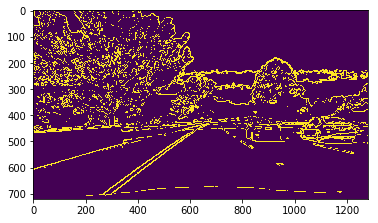

In [9]:
img_mag = mag_thresh(dst, 7, (40, 255))
plt.imshow(img_mag)

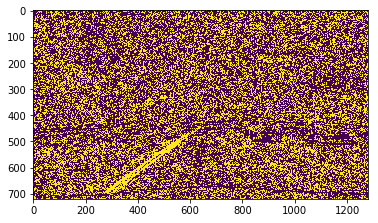

In [10]:
img_dir = dir_threshold(dst, 5, (0.7, 1.3))
plt.imshow(img_dir)

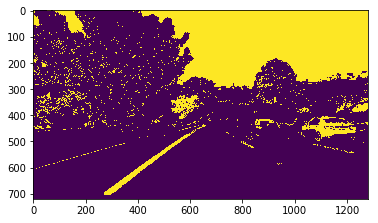

In [11]:
# Combine thresholded images
binary_output = np.zeros_like(img[:,:,0])
binary_output[((img_sobelx == 1) & (img_sobely == 1)) | (hls_thresh_img == 1)] = 1
plt.imshow(binary_output)

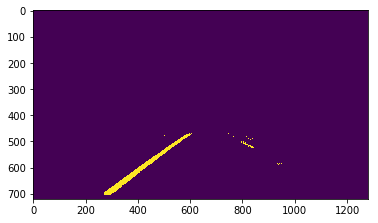

In [12]:
# Region masking
y_size, x_size = img.shape[0], img.shape[1]
vertices = np.array([[(x_size*0.05, y_size), 
                      (x_size*0.40, y_size*0.65), 
                      (x_size*0.63, y_size*0.65), 
                      (x_size*0.95, y_size)]], dtype=np.int32)
mask_img = region_of_interest(binary_output, vertices)
plt.imshow(mask_img)

/Users/donald/anaconda3/envs/tf36/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


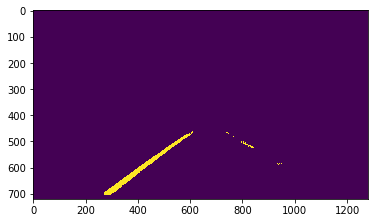

In [13]:
# Finding lines with Hough Alg.
hough_mask_img, pts = hough_lines(mask_img, rho=2, theta=np.pi/180, min_line_len=20, max_line_gap=30, threshold=10)
binary_output_ = np.zeros_like(hough_mask_img[:,:,0])
binary_output_[(binary_output == 1) & (cv2.cvtColor(hough_mask_img, cv2.COLOR_RGB2GRAY) == 255)] = 1 
plt.imshow(binary_output_)

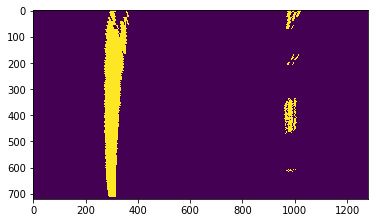

In [14]:
# Warp
margin_x = 300
margin_y_top = 0
warp_img = warper(binary_output_, np.float32(pts), np.float32([[margin_x, margin_y_top], 
                              [x_size - margin_x, margin_y_top], 
                              [x_size - margin_x, y_size], 
                              [margin_x, y_size]]))
plt.imshow(warp_img)

Curvature:2286.45 m


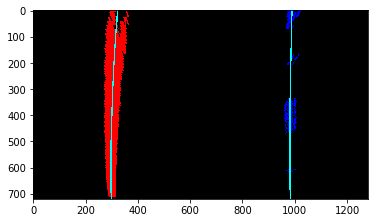

In [15]:
# Curvature calculation
poly_warp_img, ploty_m, left_fit, right_fit, l_r = fit_polynomial(warp_img)
left_curv, right_curv = measure_curvature_pixels(ploty_m, left_fit, right_fit)
beta = 1
if l_r == 0:
    curvature = left_curv * beta + right_curv * (1-beta)
else:
    curvature = left_curv * (1-beta) + right_curv * beta
print("Curvature:{} m".format(round(curvature, 2)))
plt.imshow(poly_warp_img)

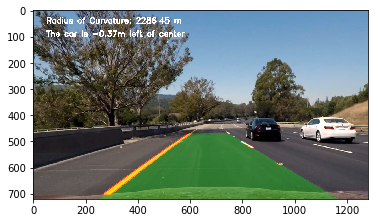

In [16]:
# Draw
color_binary_output_ = binary_output_.copy()
color_binary_output_[0:int(y_size*0.65), :] = 0
lanes_overlay = np.zeros_like(dst_)
lanes_overlay[color_binary_output_ == 1] = [255, 0, 0]

overlay = dst_.copy()
pts = np.array(pts, np.int32)
cv2.fillPoly(overlay,[pts],(0,255,0))
cv2.addWeighted(overlay, 0.3, dst_, 0.7, 0, dst_)
cv2.addWeighted(lanes_overlay, 1.0, dst_, 1.0, 0, dst_)
cv2.putText(dst_, "Radius of Curvature: {} m".format(round(curvature, 2)), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
xm_per_pix = 3.7 / 700
center_bias = xm_per_pix * (x_size/2 - (pts[3][0] + pts[2][0])/2)
f = lambda x: "right" if x > 0 else "left"
cv2.putText(dst_, "The car is {}m {} of center".format(round(center_bias, 2), f(center_bias)), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
plt.imshow(dst_)

### Pipeline

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
slope_Q_l, slope_Q_r = np.array([]), np.array([])
temp_pts = [[], [], [], []]

def process_image(img):
    
    
    # Undistortion
    dst = cv2.undistort(img, mtx, dist)
    dst_ = copy.deepcopy(dst)
    
    # Color thresholding
    hls_thresh_img = hls_select(dst, thresh2=(40, 255), thresh3=(90, 255))
    mask_color_img = np.ones_like(dst) * 255
    
    # Color (S,L) enhancement
    dst = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    dst[(hls_thresh_img == 1), 1:3] += 70
    dst = cv2.cvtColor(dst, cv2.COLOR_HLS2RGB)
    dst = cv2.GaussianBlur(dst, (3, 3), 0)
    
    # Gradients thresholding
    img_sobelx = abs_sobel_thresh(dst, 'x', 20, 255)
    img_sobely = abs_sobel_thresh(dst, 'y', 40, 255)
    img_mag = mag_thresh(dst, 7, (40, 255))
    img_dir = dir_threshold(dst, 5, (0.7, 1.3))
    
    # Threshold combination
    binary_output = np.zeros_like(img[:,:,0])
    binary_output[((img_sobelx == 1) & (img_sobely == 1)) | (hls_thresh_img == 1)] = 1
    
    # Region masking
    y_size, x_size = img.shape[0], img.shape[1]
    vertices = np.array([[(x_size*0.05, y_size), 
                          (x_size*0.43, y_size*0.65), 
                          (x_size*0.63, y_size*0.65), 
                          (x_size*0.95, y_size)]], dtype=np.int32)
    mask_img = region_of_interest(binary_output, vertices)
    
    # Finding lines with Hough Alg.
    mask_img, pts = hough_lines(mask_img, rho=2, theta=np.pi/180, min_line_len=30, max_line_gap=50, threshold=15)
    left_slope, right_slope = np.arctan((pts[0][1] - pts[3][1]) / (pts[0][0] - pts[3][0])), np.arctan((pts[1][1] - pts[2][1]) / (pts[1][0] - pts[2][0]))
    
    global slope_Q_l, slope_Q_r, temp_pts
    if len(slope_Q_l) > 0 and np.abs(left_slope - np.average(slope_Q_l, axis=0)) > 10:
        pts[0], pts[3] = temp_pts[0], temp_pts[3]
    else:
        slope_Q_l = np.insert(slope_Q_l, 0, np.arctan((pts[0][1] - pts[3][1]) / (pts[0][0] - pts[3][0])), axis=0)
        temp_pts[0], temp_pts[3] = pts[0], pts[3]
        if len(slope_Q_l) == 10:
            slope_Q_l = np.delete(slope_Q_l, 9, axis=0)
    
    if len(slope_Q_r) > 0 and np.abs(right_slope - np.average(slope_Q_r, axis=0)) > 10:
        pts[1], pts[2] = temp_pts[1], temp_pts[2]
    else:
        slope_Q_r = np.insert(slope_Q_l, 0, np.arctan((pts[1][1] - pts[2][1]) / (pts[1][0] - pts[2][0])), axis=0)
        temp_pts[1], temp_pts[2] = pts[1], pts[2]
        if len(slope_Q_r) == 10:
            slope_Q_r = np.delete(slope_Q_r, 9, axis=0)

    binary_output_ = np.zeros_like(mask_img[:,:,0])
    binary_output_[(binary_output == 1) & (cv2.cvtColor(mask_img, cv2.COLOR_RGB2GRAY) == 255)] = 1    
    
    
    # Warp
    margin_x = 300
    margin_y_top = 0
    warp_img = warper(binary_output_, np.float32(pts), np.float32([[margin_x, margin_y_top], 
                                  [x_size - margin_x, margin_y_top], 
                                  [x_size - margin_x, y_size], 
                                  [margin_x, y_size]]))

    # Curvature calculation
    poly_warp_img, ploty_m, left_fit, right_fit, l_r = fit_polynomial(warp_img)
    left_curv, right_curv = measure_curvature_pixels(ploty_m, left_fit, right_fit)
    beta = 1
    if l_r == 0:
        curvature = left_curv * beta + right_curv * (1-beta)
    else:
        curvature = left_curv * (1-beta) + right_curv * beta
    
    # Draw
    color_binary_output_ = binary_output_.copy()
    color_binary_output_[0:int(y_size*0.65), :] = 0
    lanes_overlay = np.zeros_like(dst_)
    lanes_overlay[color_binary_output_ == 1] = [255, 0, 0]
    
    overlay = dst_.copy()
    pts = np.array(pts, np.int32)
    cv2.fillPoly(overlay,[pts],(0,255,0))
    cv2.addWeighted(overlay, 0.3, dst_, 0.7, 0, dst_)
    cv2.addWeighted(lanes_overlay, 1.0, dst_, 1.0, 0, dst_)
    cv2.putText(dst_, "Radius of Curvature: {} m".format(round(curvature, 2)), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
    xm_per_pix = 3.7 / 700
    center_bias = xm_per_pix * (x_size/2 - (pts[3][0] + pts[2][0])/2)
    f = lambda x: "right" if x > 0 else "left"
    cv2.putText(dst_, "The car is {}m {} of center".format(np.absolute(round(center_bias, 2)), f(center_bias)), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
    
    # Create canvas
    canvas = np.zeros((y_size, x_size, 3))
    # Resize Images
    binary_output_ = cv2.resize(binary_output_, (int(x_size * 0.5), int(y_size * 0.5)))
    dst_ = cv2.resize(dst_, (int(x_size * 0.5), int(y_size * 0.5)))
    poly_warp_img = cv2.resize(poly_warp_img, (int(x_size * 0.5), int(y_size * 0.5)))
    # Fill canvas
    half_x_size, half_y_size = int(0.5*x_size), int(0.5*y_size)
    canvas[0:half_y_size, 0:half_x_size,:] = cv2.cvtColor(binary_output_, cv2.COLOR_GRAY2RGB) * 255
    canvas[0:half_y_size, half_x_size:, :] = poly_warp_img
    canvas[half_y_size:, 0:half_x_size,:] = dst_
    
#     return canvas
    return dst_

### Process and Display Video

In [19]:
import time
white_output = 'processed_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████▉| 1260/1261 [06:13<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

CPU times: user 5min 43s, sys: 51.8 s, total: 6min 35s
Wall time: 6min 13s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))